In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('merged_fips_moving_average_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994 entries, 0 to 3993
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   time_value                               3994 non-null   object 
 1   geo_value                                3994 non-null   int64  
 2   smoothed_wspent_time_1d                  3994 non-null   float64
 3   smoothed_wtested_14d                     3994 non-null   float64
 4   smoothed_wpublic_transit_1d              3994 non-null   float64
 5   smoothed_wworried_become_ill             3994 non-null   float64
 6   smoothed_wvaccine_likely_govt_health     3994 non-null   float64
 7   smoothed_wshop_1d                        3994 non-null   float64
 8   smoothed_wtested_positive_14d            3994 non-null   float64
 9   smoothed_wwork_outside_home_1d           3994 non-null   float64
 10  smoothed_wothers_masked                  3994 no

In [13]:
# Drop one variable from each highly correlated pair
highly_corr_to_drop = [
    "smoothed_wvaccine_likely_govt_health",  # drop in favor of smoothed_wvaccine_likely_who
    "smoothed_wwearing_mask"                 # drop in favor of smoothed_wothers_masked
]

# Drop the columns
data = data.drop(columns=highly_corr_to_drop)

data.columns

Index(['time_value', 'geo_value', 'smoothed_wspent_time_1d',
       'smoothed_wtested_14d', 'smoothed_wpublic_transit_1d',
       'smoothed_wworried_become_ill', 'smoothed_wshop_1d',
       'smoothed_wtested_positive_14d', 'smoothed_wwork_outside_home_1d',
       'smoothed_wothers_masked', 'smoothed_wcli',
       'smoothed_wcovid_vaccinated', 'smoothed_wvaccine_likely_friends',
       'smoothed_wrestaurant_1d', 'smoothed_wvaccine_likely_politicians',
       'smoothed_wvaccine_likely_who', 'smoothed_wlarge_event_1d',
       'FIPS State', 'FIPS County', 'State', 'County Name',
       'smoothed_wcli_lagged', 'smoothed_wpublic_transit_1d_lagged',
       'smoothed_wcovid_vaccinated_lagged',
       'smoothed_wvaccine_likely_friends_lagged'],
      dtype='object')

In [14]:
data.columns

Index(['time_value', 'geo_value', 'smoothed_wspent_time_1d',
       'smoothed_wtested_14d', 'smoothed_wpublic_transit_1d',
       'smoothed_wworried_become_ill', 'smoothed_wshop_1d',
       'smoothed_wtested_positive_14d', 'smoothed_wwork_outside_home_1d',
       'smoothed_wothers_masked', 'smoothed_wcli',
       'smoothed_wcovid_vaccinated', 'smoothed_wvaccine_likely_friends',
       'smoothed_wrestaurant_1d', 'smoothed_wvaccine_likely_politicians',
       'smoothed_wvaccine_likely_who', 'smoothed_wlarge_event_1d',
       'FIPS State', 'FIPS County', 'State', 'County Name',
       'smoothed_wcli_lagged', 'smoothed_wpublic_transit_1d_lagged',
       'smoothed_wcovid_vaccinated_lagged',
       'smoothed_wvaccine_likely_friends_lagged'],
      dtype='object')

# Original features

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('merged_fips_moving_average_data.csv')
# Drop one variable from each highly correlated pair
highly_corr_to_drop = [
    "smoothed_wvaccine_likely_govt_health",  # drop in favor of smoothed_wvaccine_likely_who
    "smoothed_wwearing_mask"                 # drop in favor of smoothed_wothers_masked
]

# Drop the columns
data = data.drop(columns=highly_corr_to_drop)

from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# --- Define target and features ---
target_col = "smoothed_wtested_positive_14d"

current_features = [
    'smoothed_wspent_time_1d',
    'smoothed_wtested_14d',       
    'smoothed_wworried_become_ill',
    'smoothed_wshop_1d',
    'smoothed_wwork_outside_home_1d',
    'smoothed_wothers_masked',
    'smoothed_wrestaurant_1d',
    'smoothed_wvaccine_likely_who',
    'smoothed_wlarge_event_1d',  
]

lagged_features_original = [
    'smoothed_wcli',
    'smoothed_wpublic_transit_1d',
    'smoothed_wcovid_vaccinated',
    'smoothed_wvaccine_likely_friends',
]

lagged_features = [
    'smoothed_wcli_lagged',
    'smoothed_wpublic_transit_1d_lagged',
    'smoothed_wcovid_vaccinated_lagged',
    'smoothed_wvaccine_likely_friends_lagged'
]

all_features = current_features + lagged_features_original

# --- Preprocess: sort and create lags ---
def create_lagged_target(df, col, max_lag=2):
    for lag in range(1, max_lag + 1):
        df[f"{col}_lag{lag}"] = df.groupby("geo_value")[col].shift(lag)
    return df

data = data.sort_values(["geo_value", "time_value"])
data = create_lagged_target(data, target_col)

# --- Temporal train/val/test split ---
cut80 = int(len(data) * 0.8)
cut90 = int(len(data) * 0.9)
train_cut = data.iloc[cut80]["time_value"]
val_cut = data.iloc[cut90]["time_value"]

train = data[data["time_value"] < train_cut].copy()
val = data[(data["time_value"] >= train_cut) & (data["time_value"] < val_cut)].copy()
test = data[data["time_value"] >= val_cut].copy()

# --- Drop rows with missing values ---
train.dropna(subset=all_features + [target_col], inplace=True)
val.dropna(subset=all_features + [target_col], inplace=True)
test.dropna(subset=all_features + [target_col], inplace=True)

# --- Extract matrices ---
X_train = train[all_features].values
y_train = train[target_col].values

X_val = val[all_features].values
y_val = val[target_col].values

X_test = test[all_features].values
y_test = test[target_col].values

# --- Train Ridge with 5-Fold CV ---
alphas = np.logspace(-4, 4, 20)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

ridge = RidgeCV(alphas=alphas, cv=cv)
ridge.fit(X_train, y_train)

# --- Predict on test set ---
y_pred = ridge.predict(X_test)

# --- Evaluate ---
print("=== Simple Ridge Regression Results ===")
print(f"Best alpha (5-fold CV): {ridge.alpha_:.6f}")
print(f"Test R²:   {r2_score(y_test, y_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_pred):.4f}")


=== Simple Ridge Regression Results ===
Best alpha (5-fold CV): 29.763514
Test R²:   -0.7955
Test RMSE: 2.4028
Test MAE:  1.8564


                             Feature  Coefficient  Abs Coef
10       smoothed_wpublic_transit_1d    -0.380246  0.380246
5            smoothed_wothers_masked    -0.331438  0.331438
12  smoothed_wvaccine_likely_friends     0.319087  0.319087
2       smoothed_wworried_become_ill     0.253130  0.253130
7       smoothed_wvaccine_likely_who    -0.230145  0.230145
1               smoothed_wtested_14d    -0.201585  0.201585
11        smoothed_wcovid_vaccinated    -0.171640  0.171640
6            smoothed_wrestaurant_1d    -0.164431  0.164431
9                      smoothed_wcli     0.132903  0.132903
4     smoothed_wwork_outside_home_1d     0.119198  0.119198
3                  smoothed_wshop_1d     0.118475  0.118475
0            smoothed_wspent_time_1d    -0.089347  0.089347
8           smoothed_wlarge_event_1d     0.067912  0.067912


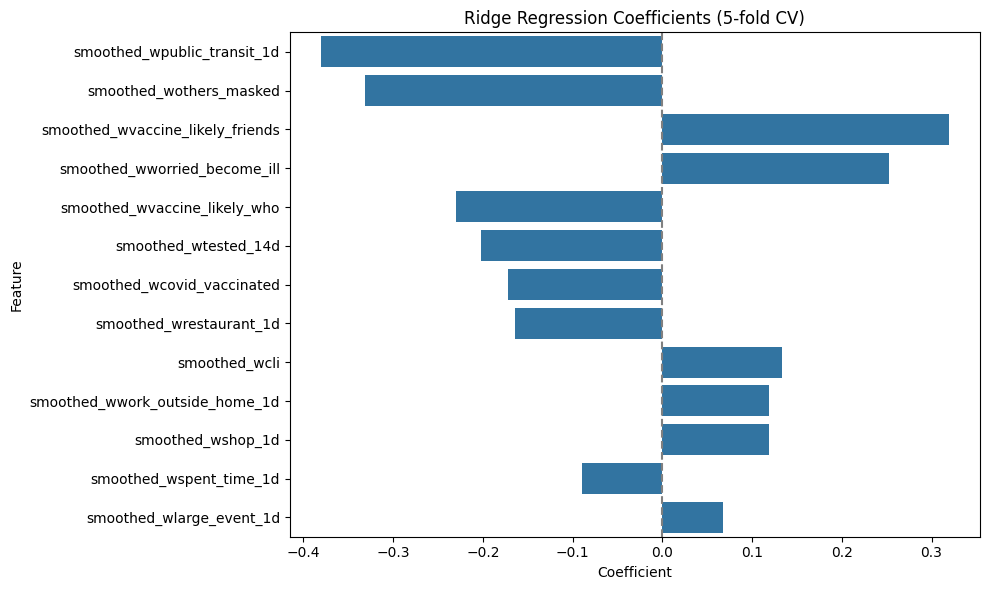

In [16]:
# Match features to coefficients
coef_df = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": ridge.coef_
})
coef_df["Abs Coef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs Coef", ascending=False)

print(coef_df)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Ridge Regression Coefficients (5-fold CV)")
plt.tight_layout()
plt.show()